In [161]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.io.fits as pyfits
import pandas as pd
import scipy
from   uncertainties import ufloat
import math
import os

#### Ορισμός γεωμετρικών στοιχείων

In [162]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

def get_distance(point1, point2):
    return np.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

origin = Point(0, 0)

class Circle:
    def __init__(self, center, radius):
        self.center = center
        self.radius = radius

    def is_in_ball(self, point):
        return get_distance(self.center, point) - self.radius <= 0
    
    def is_in_circle(self, point):
        return get_distance(self.center, point) - self.radius == 0
    
    def are_in_ball(self, points):
        return [self.is_in_ball(point) for point in points]
    
    def are_in_circle(self, points):
        return [self.is_in_circle(point) for point in points]
    
# απόσταση από pixel σε λεπτά
def pixel_to_arcmin(pixel):
    return pixel * 0.0392

#### Δεδομένα φωτογραφιών

In [163]:
# για κάποιον λόγο τίθεται η ενεργός διαδρομή στον φάκελο του VSCode 
# παρά τον φάκελο του αποθετηρίου, να το αλλάξετε αυτό ανά περίπτωση
# Υπενθύμιση ότι το `CODE_REPOS_1` είναι εμή μεταβλητή περιβάλλοντος,
# οπότε ο κώδικας *δεν* θα τρέξει αν δεν την αλλάξετε (ή δεν την ορίσετε)
work_directory = os.path.join(os.environ["CODE_REPOS_1"], "lab-team/")
event_path = os.path.join(work_directory, "events/")

event_files = [os.path.join(event_path, f) for f in os.listdir(event_path) if f.endswith(".evt.gz")]
event_number = len(event_files)
#source_fits_file = "source_data.fits.gz"

events = [pyfits.open(event_file) for event_file in event_files]

#### Ταξινόμηση φωτογραφιών χρονολογικά

In [164]:
event_headers = [event[1].header for event in events]
event_times = [(1/2)*(event_header["TSTOP"] + event_header["TSTART"])for event_header in event_headers]

events = [event for _, event in sorted(zip(event_times, events))]
event_times_sorted_immutable = sorted(event_times)
event_times_sorted = event_times_sorted_immutable.copy() # προχειροδουλειά που θα χρησιμεύσει αργότερα

event_headers = [event[1].header for event in events]
event_data = [event[1].data for event in events]

#### Επιλογή δοκιμαστικής φωτογραφίας
Πρέπει να επεξεργάζεστε ανά περίπτωση τα όρια των διαγραμμάτων (δεν είναι όμως απαραίτητο, καθώς τα διαγράμματα επιτελούν καθαρά σκοπούς οπτικοποίησης. Εφόσον το κέντρο βρίσκεται εντός των ορίων, δεν απαιτείται επεξεργασία)

In [165]:
event_index = 10

if event_index >= len(event_data):
    event_index = len(event_data) - 1
    print("\033[91mEvent index out of bounds, setting to last event\033[0m")

source_data = event_data[event_index]

source_x_limits = Point(350, 780)
source_y_limits = Point(400, 780)

#### Προβολή φωτογραφίας

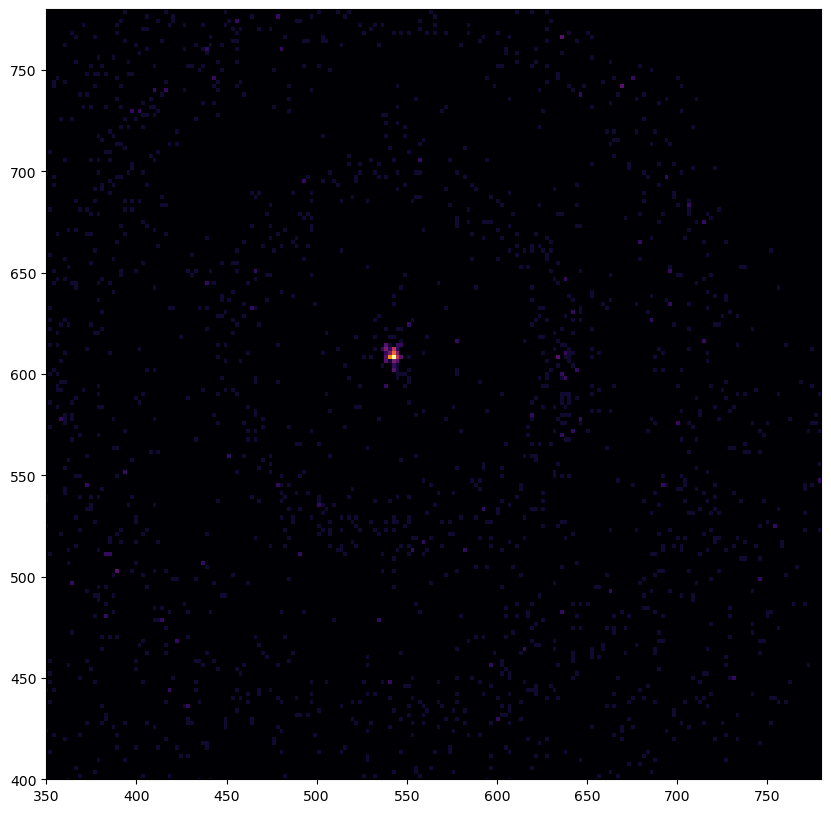

In [166]:
source_x_coords = source_data['X']
source_y_coords = source_data['Y']

plt.close('all')
plt.figure(1,figsize=(10,10))
plt.hist2d(source_x_coords, source_y_coords, bins=300, cmap='inferno')
plt.xlim(source_x_limits.x, source_x_limits.y)
plt.ylim(source_y_limits.x, source_y_limits.y)
plt.show()

#### Ορισμός Γεωμετρικών Χαρακτηριστικών εικόνας
Πρέπει να επεξεργάζεστε ανά περίπτωση το κέντρο του άστρου. Η ακτίνα δεν απαιτεί αλλαγή, καθώς είναι καθαρά για λόγους οπτικοποίησης

In [167]:
source_center_x = 540
source_center_y = 610
source_radius = 50

source_origin = Point(source_center_x, source_center_y)
source_circle = Circle(source_origin, source_radius)

#### Επικύρωση κέντρου
Χρησιμεύει για μια «με το μάτι» επιβεβαίωση της σωστής επιλογής του κέντρου. Μπορείτε επίσης να χρησιμοποιήσετε το αποτέλεσμα του διαγράμματος πλησίον του μηδενός για να επιβεβαιώσετε αν πήρατε καλά το κέντρο.

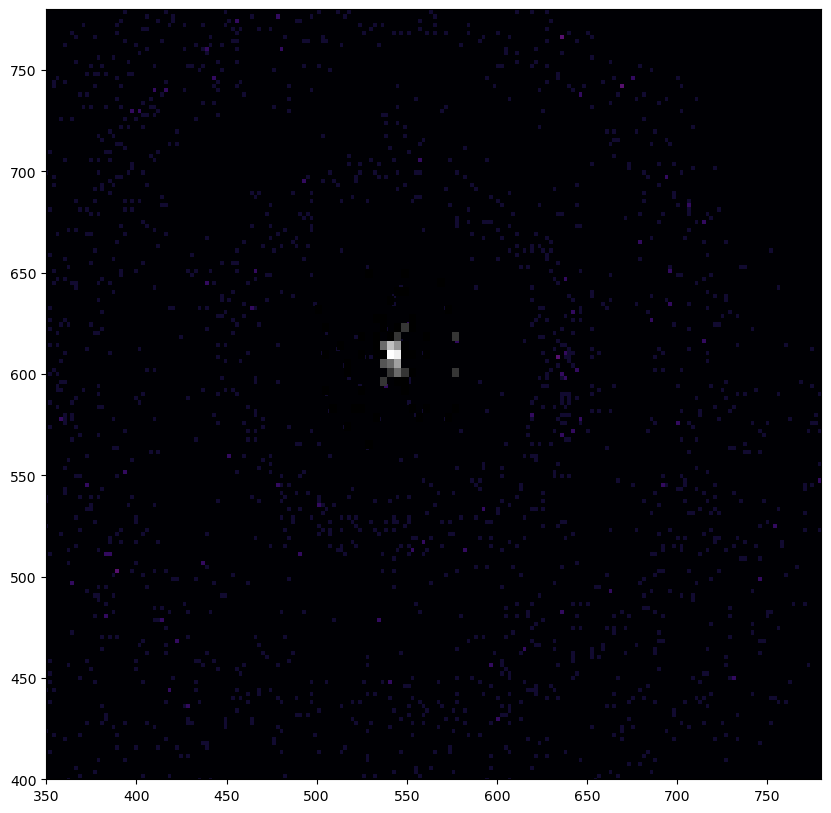

In [168]:
source_points = np.array([Point(x, y) for x, y in zip(source_x_coords, source_y_coords)])

source_origin_mask = source_circle.are_in_ball(source_points)

masked_source_points = source_points[source_origin_mask]
masked_source_x_coords = np.array([point.x for point in masked_source_points])
masked_source_y_coords = np.array([point.y for point in masked_source_points])

plt.close('all')
plt.figure(1,figsize=(10,10))
plt.hist2d(source_x_coords, source_y_coords, bins=300, cmap='inferno')
plt.hist2d(masked_source_x_coords, masked_source_y_coords, bins=20, cmap=plt.cm.gray,norm=mpl.colors.LogNorm())
plt.xlim(source_x_limits.x, source_x_limits.y)
plt.ylim(source_y_limits.x, source_y_limits.y)
plt.show()

#### Κατανομή
Η ιδέα της κατανομής είναι η εξής:
Ελέγχουμε για κάθε ανίχνευση την ακτίνα της από το εκτιμώμενο κέντρο και κάνουμε ιστόγραμμα με τις αποστάσεις

*Σημείωση: Οι κατανομές γίνονται πάνω σε όλες τις φωτογραφίες, όχι μόνο στην δοκιμαστική*

In [169]:
def get_distances_of_detections(data, origin_point = origin):
    x_coords = data['X']
    y_coords = data['Y']
    return np.array([get_distance(Point(x, y), origin_point) for x, y in zip(x_coords, y_coords)])

In [170]:
def get_all_distributions(events, origins, bin_count = 100):
    indices = range(len(events))
    for source, source_origin, index in zip(events, origins, indices):
        source_data = source[1].data
        source_header = source[1].header
        distances = get_distances_of_detections(source_data, source_origin)
        
        object_id = source_header['TELESCOP'] + source_header['OBS_ID']

        # Δεδομένα
        counts, bins = np.histogram(distances, bins = bin_count)
        bin_middle = (1/2)*(bins[1:] + bins[:-1]) # το μέσον κάθε μπάρας
        unit_bin_middle = [pixel_to_arcmin(bin) for bin in bin_middle]
        figure = plt.figure(1,figsize=(10,10))
        # Ρυθμίσεις
        plt.errorbar(unit_bin_middle, counts/unit_bin_middle, yerr=np.sqrt(counts)/unit_bin_middle, fmt='o', capsize=3) 
        plt.yscale("log")
        plt.grid("both")
        plt.title("Αριθμός ανιχνεύσεων ανά απόσταση από το κέντρο της πηγής \n[γεγονός: " + str(index) + ", κέντρο: (" + str(source_origin.x) + "," + str(source_origin.y) + ")" + ", ταυτοποίηση αντικειμένου: " + object_id + "]")
        plt.xlabel("Απόσταση από κέντρο [arcmin]")
        plt.ylabel("Αριθμός ανιχνεύσεων/απόσταση [$\log(1/arcmin)$]")
        # Αποθήκευση
        figure_name = "histograms/hist_" + str(index) + "_" + object_id + ".png"
        figure.savefig(figure_name)
        # Εμφάνιση
        plt.show()

def get_distribution_of_first_event(events, origin, bin_count = 100):
    source_data = events[0][1].data
    distances = get_distances_of_detections(source_data, origin)
    
    counts, bins = np.histogram(distances, bins = bin_count)
    bin_middle = (1/2)*(bins[1:] + bins[:-1]) # το μέσον κάθε μπάρας
    unit_bin_middle = [pixel_to_arcmin(bin) for bin in bin_middle]
    return unit_bin_middle, counts/unit_bin_middle

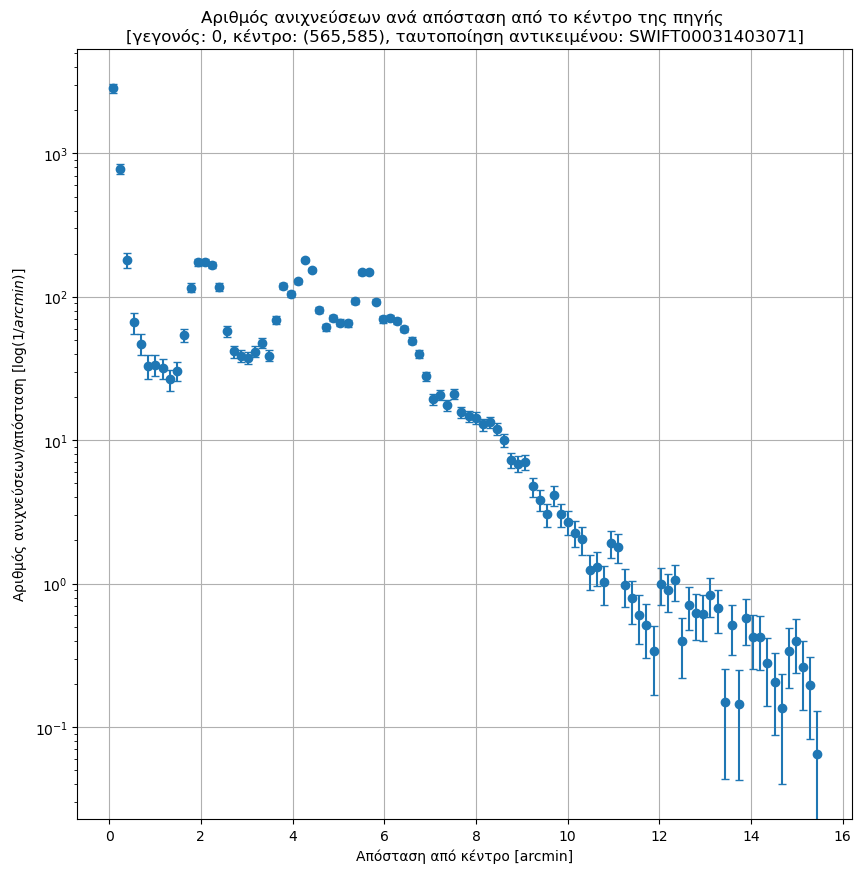

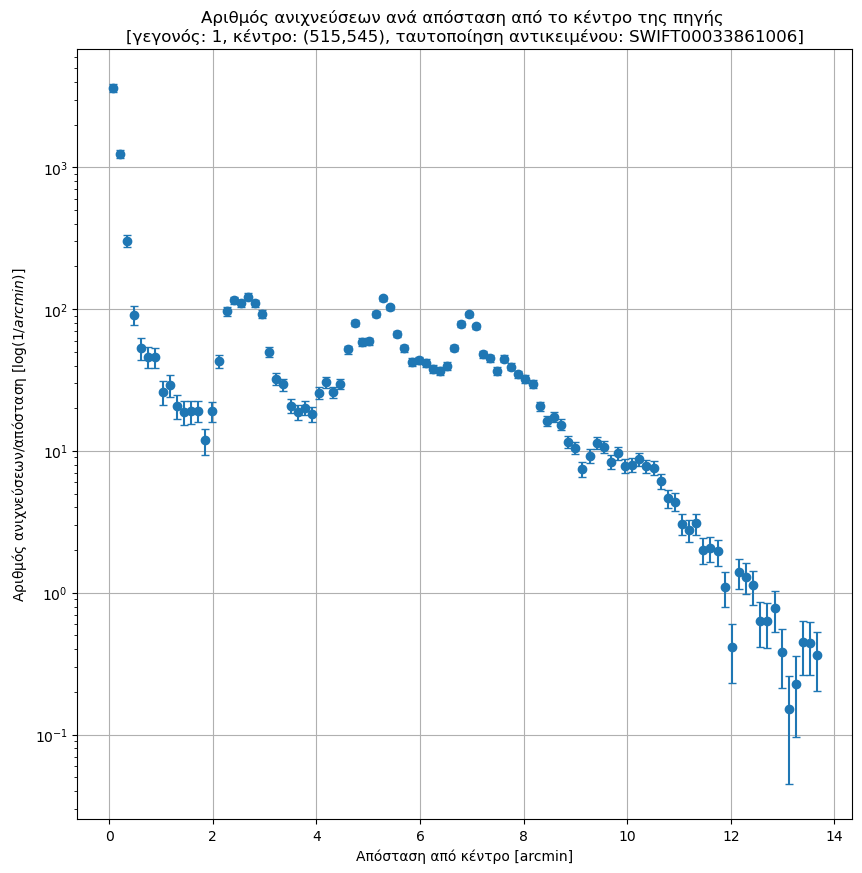

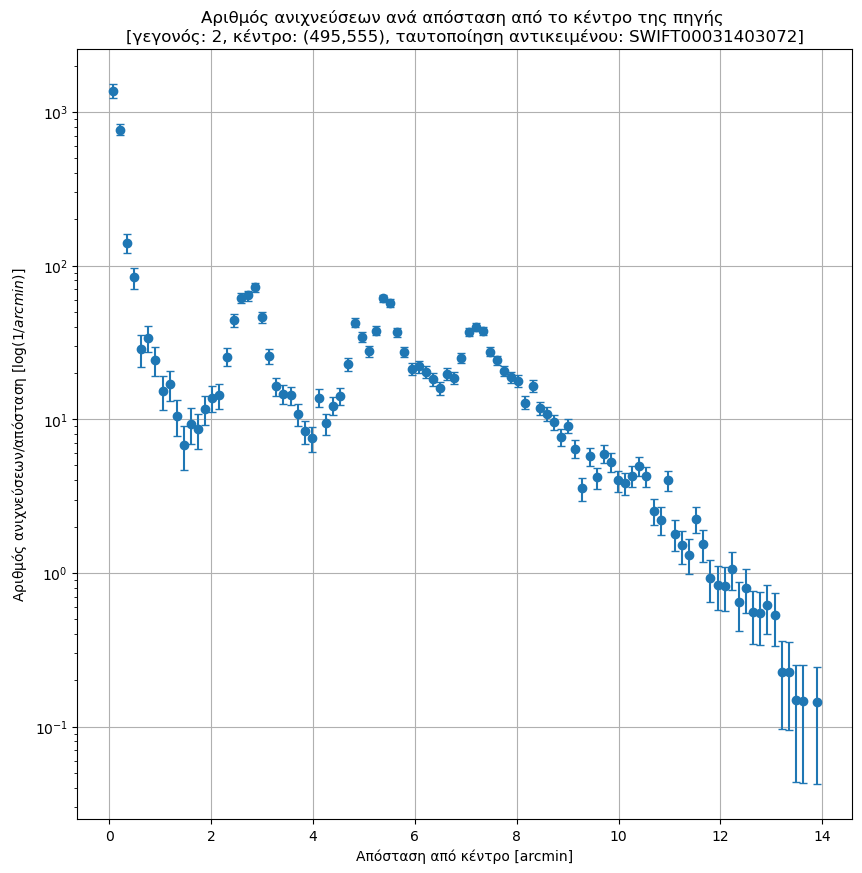

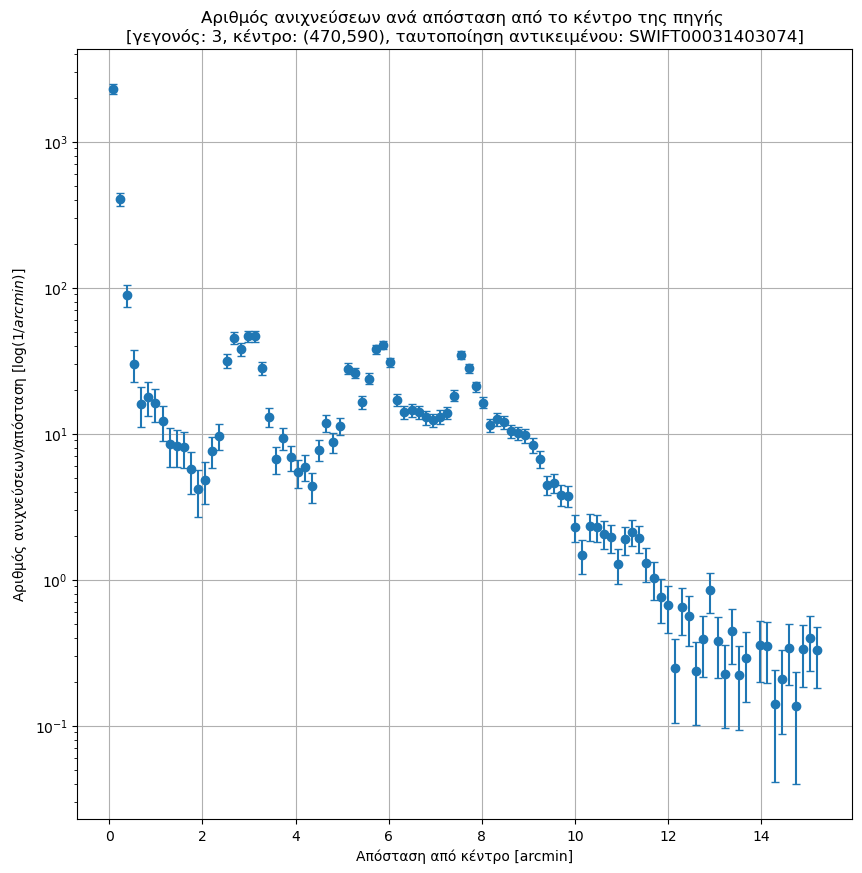

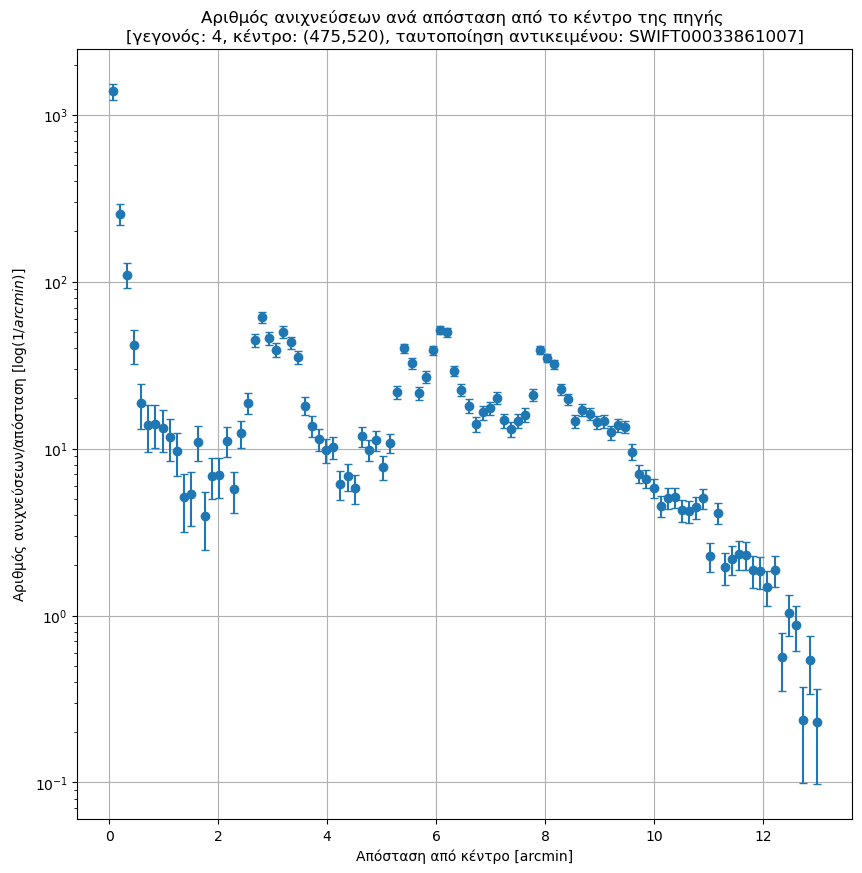

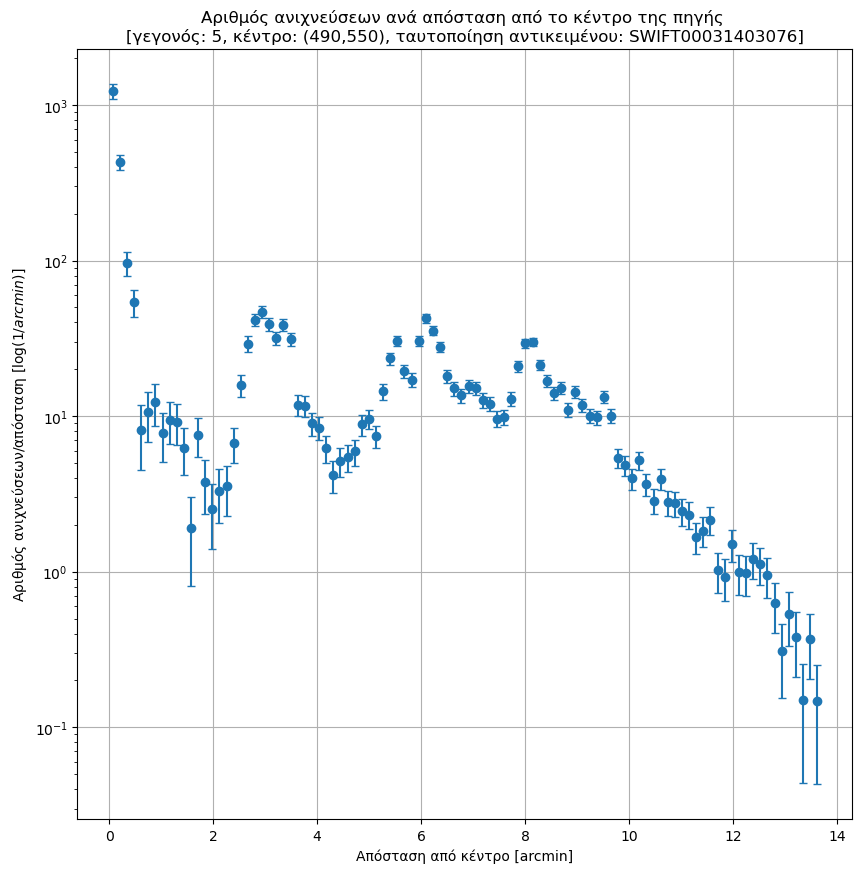

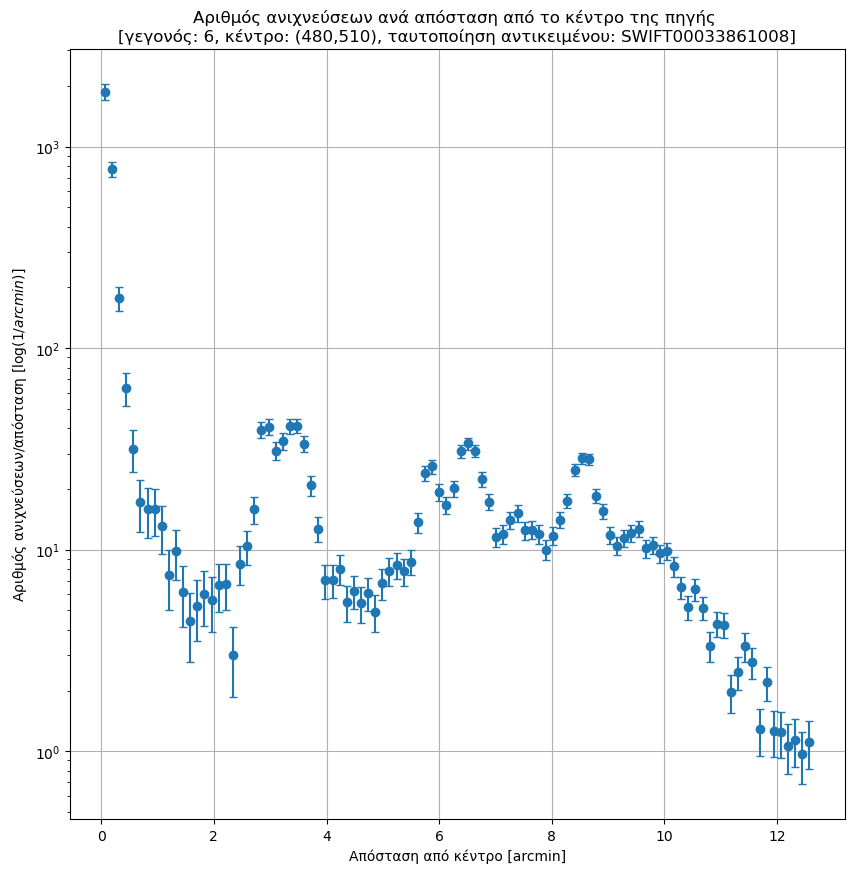

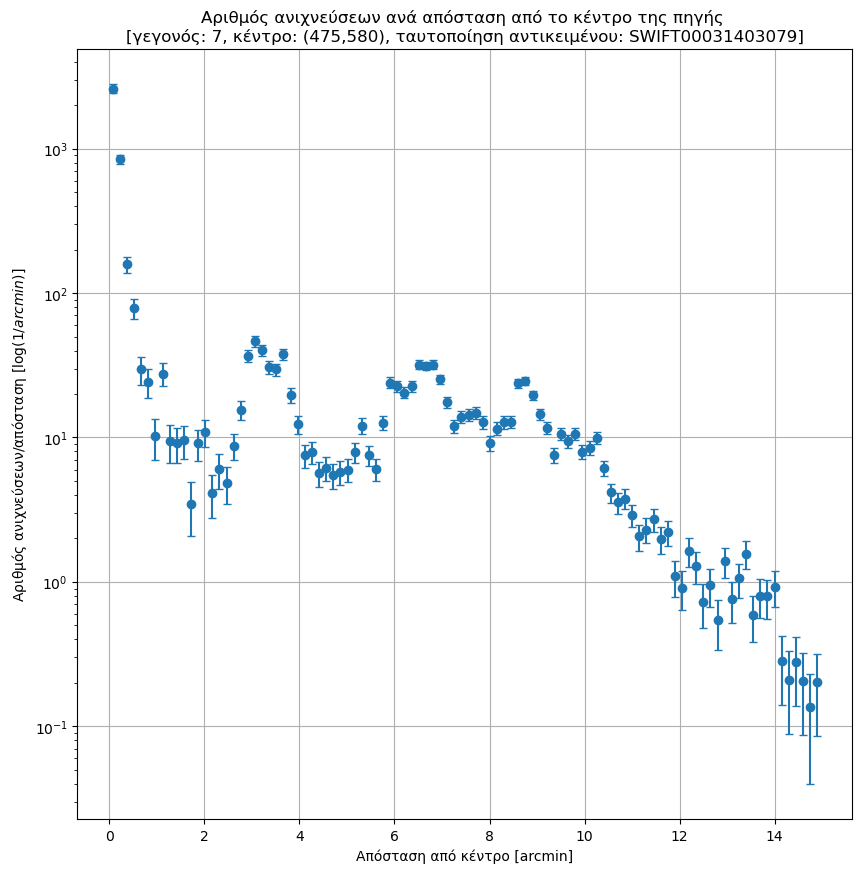

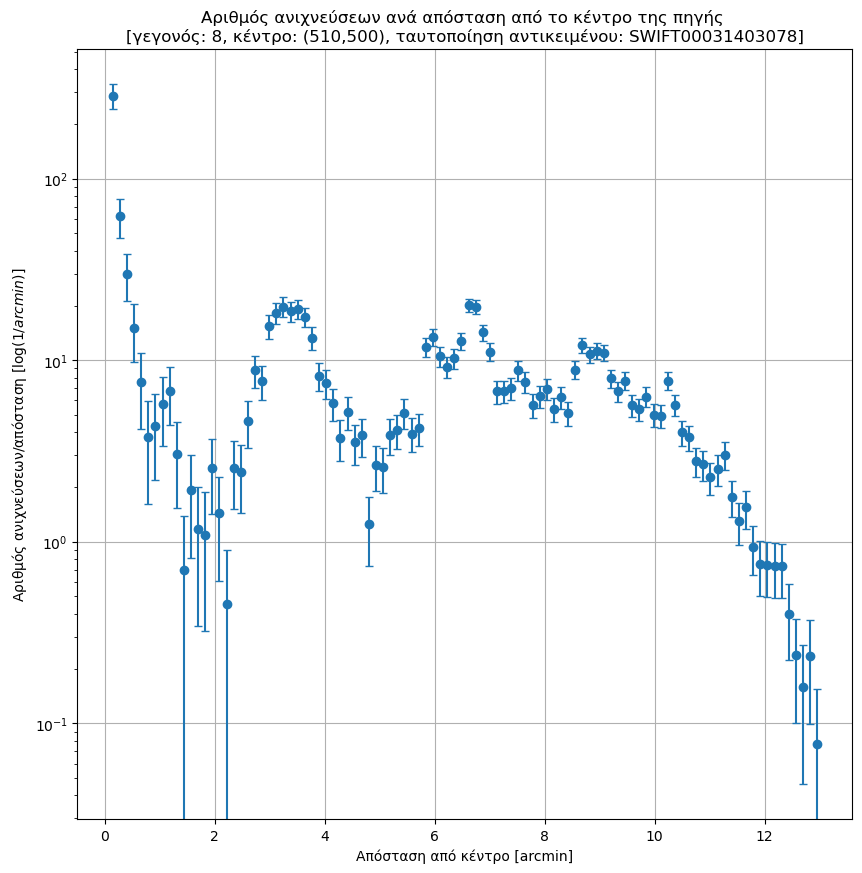

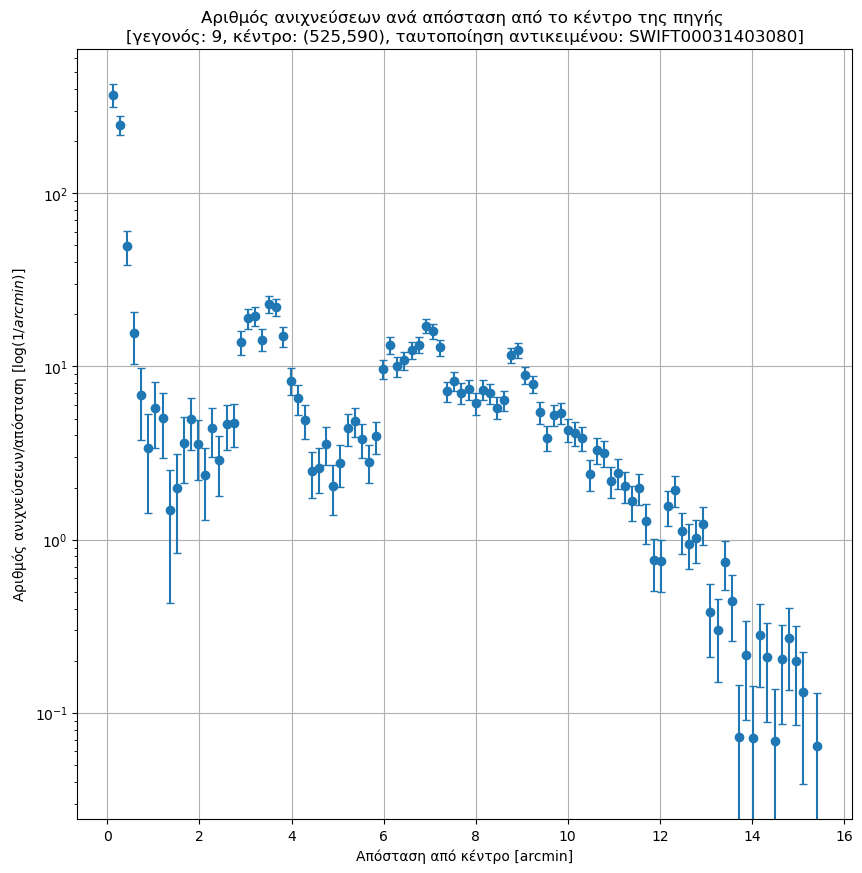

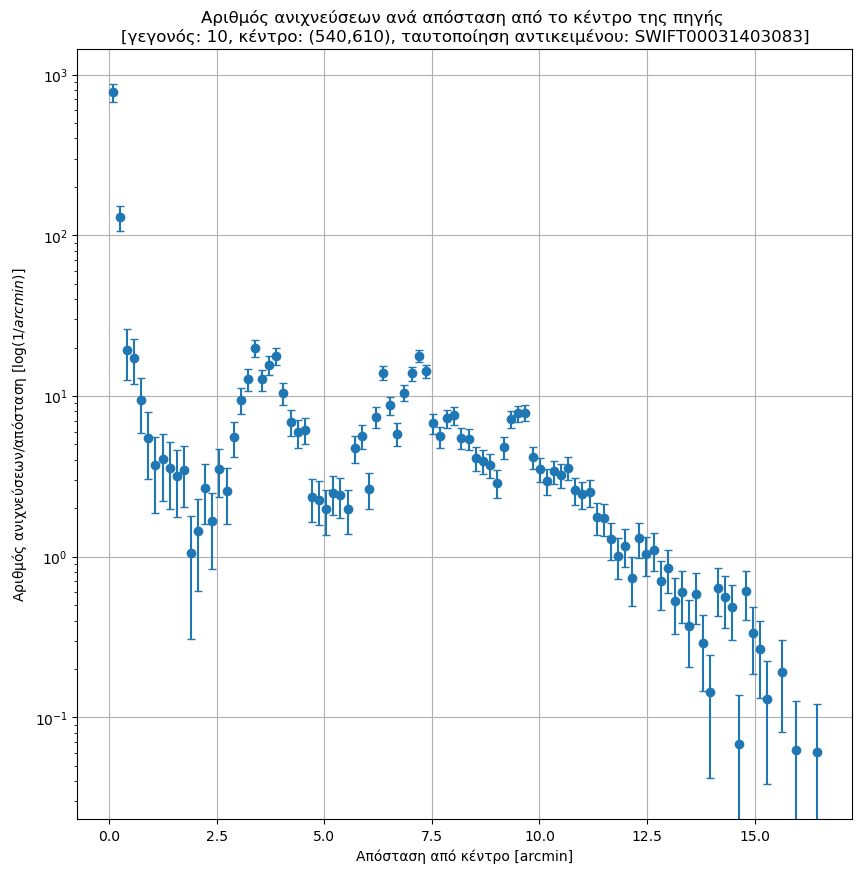

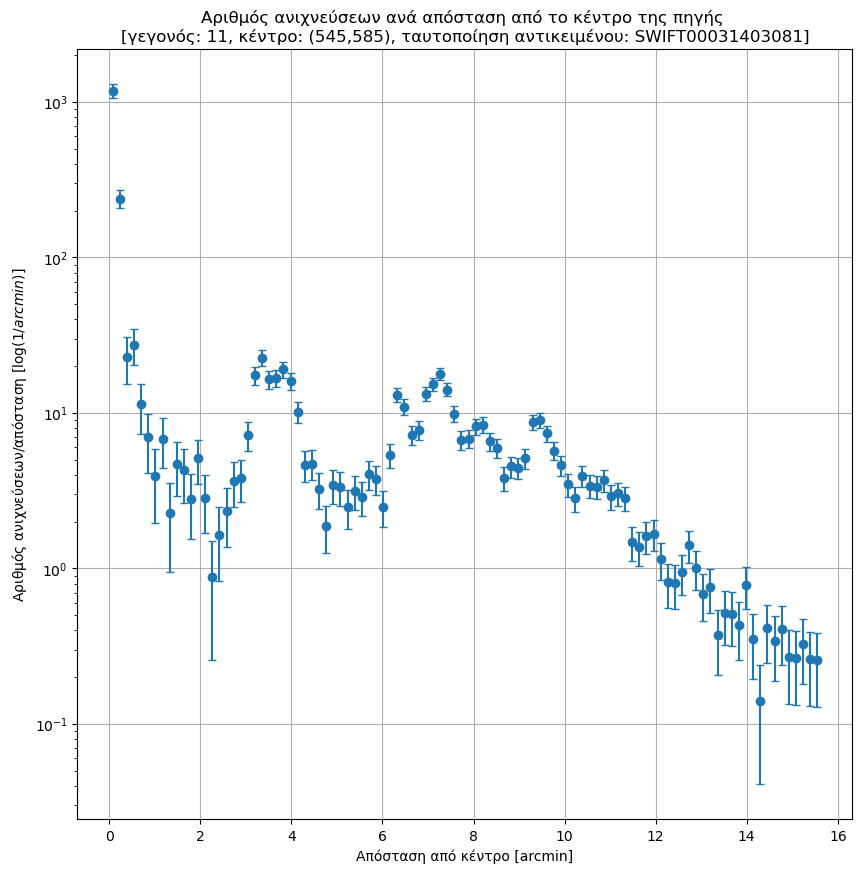

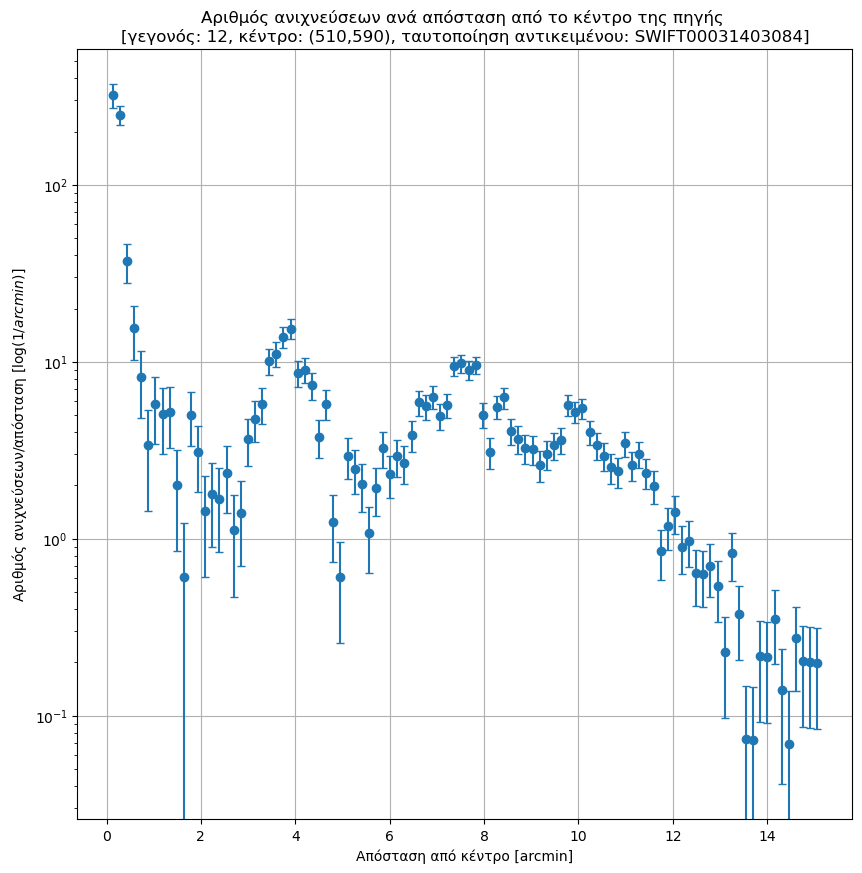

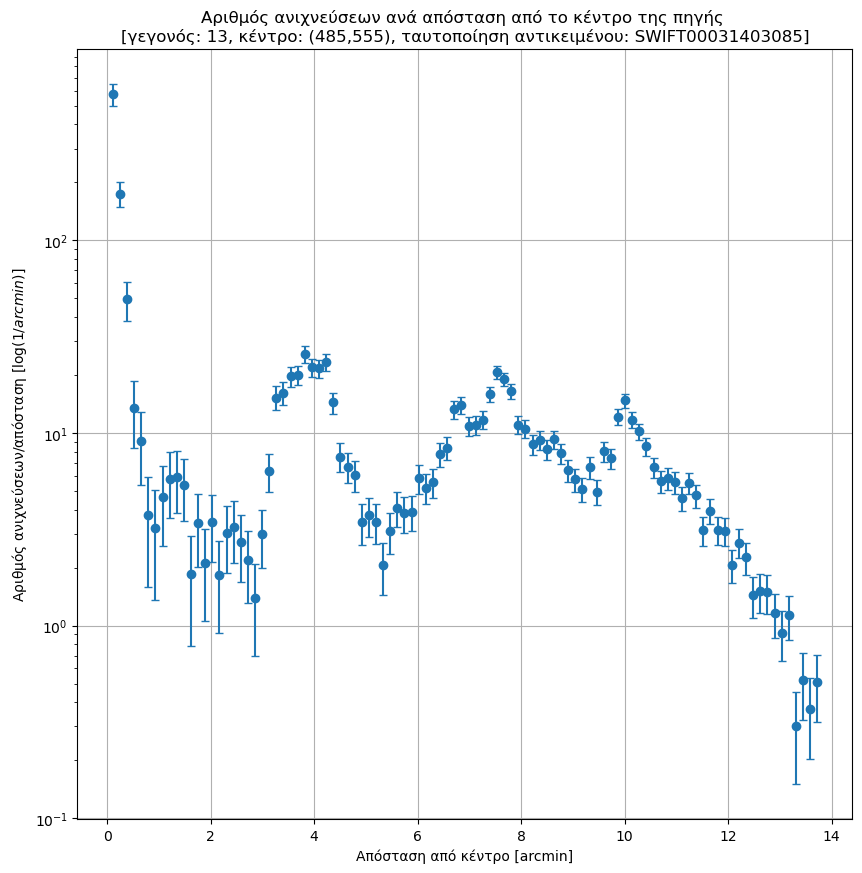

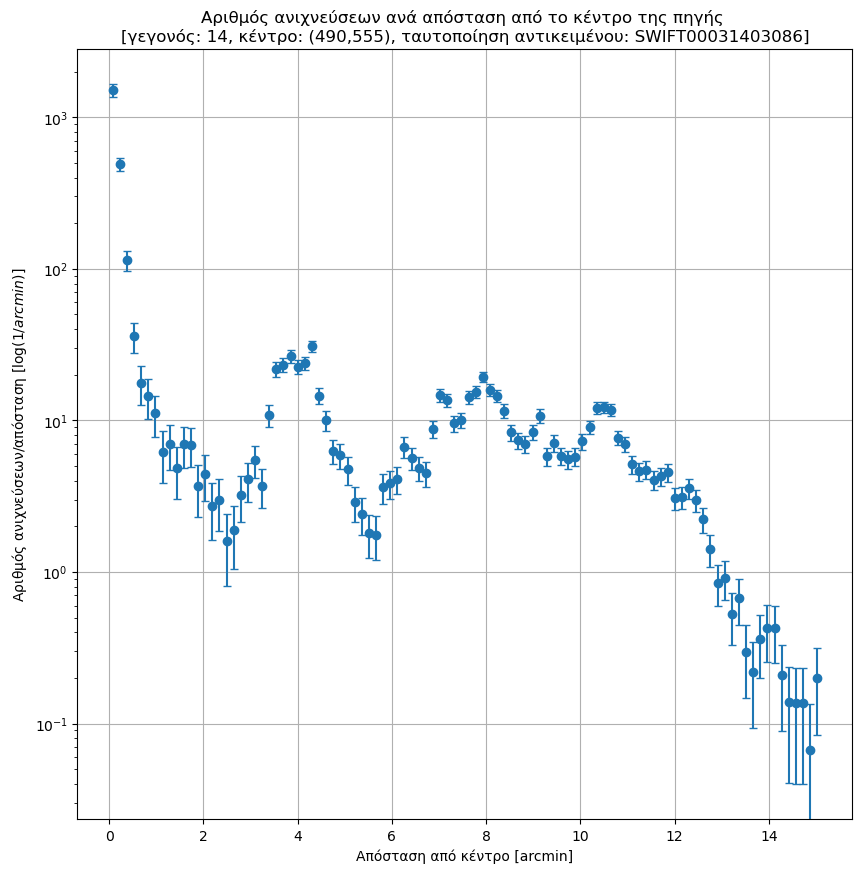

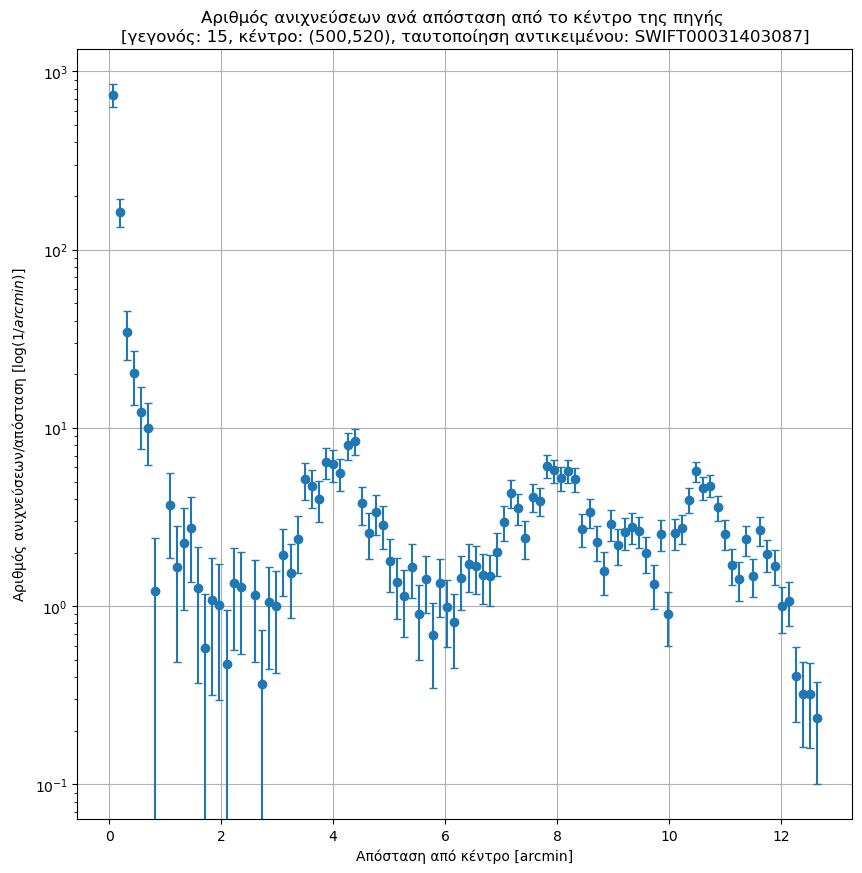

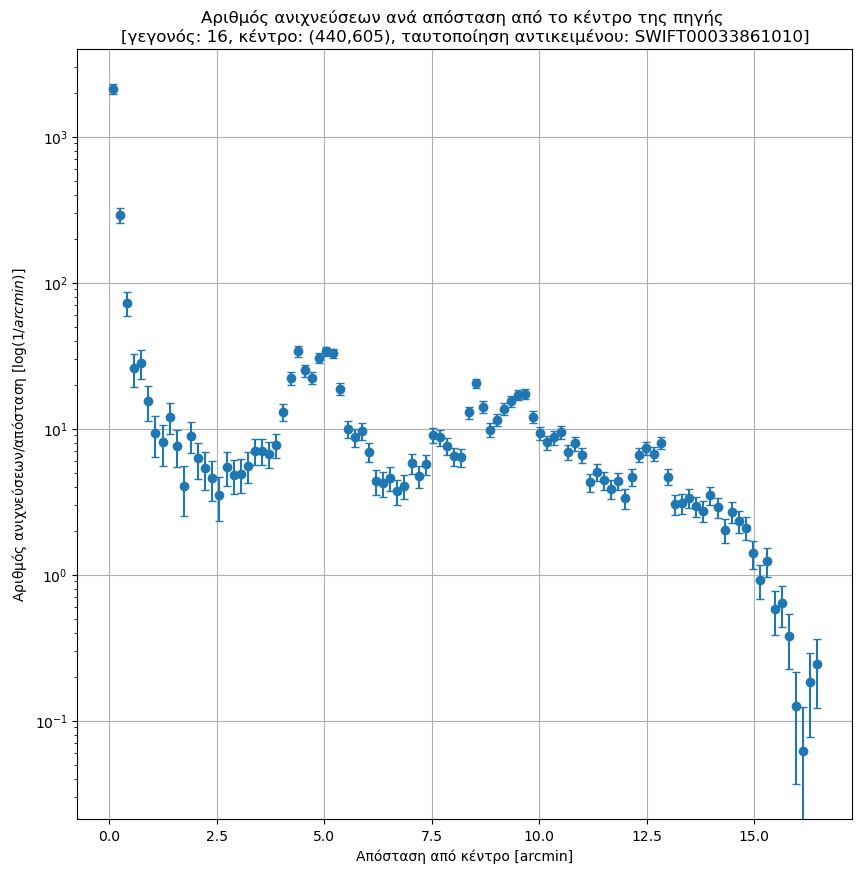

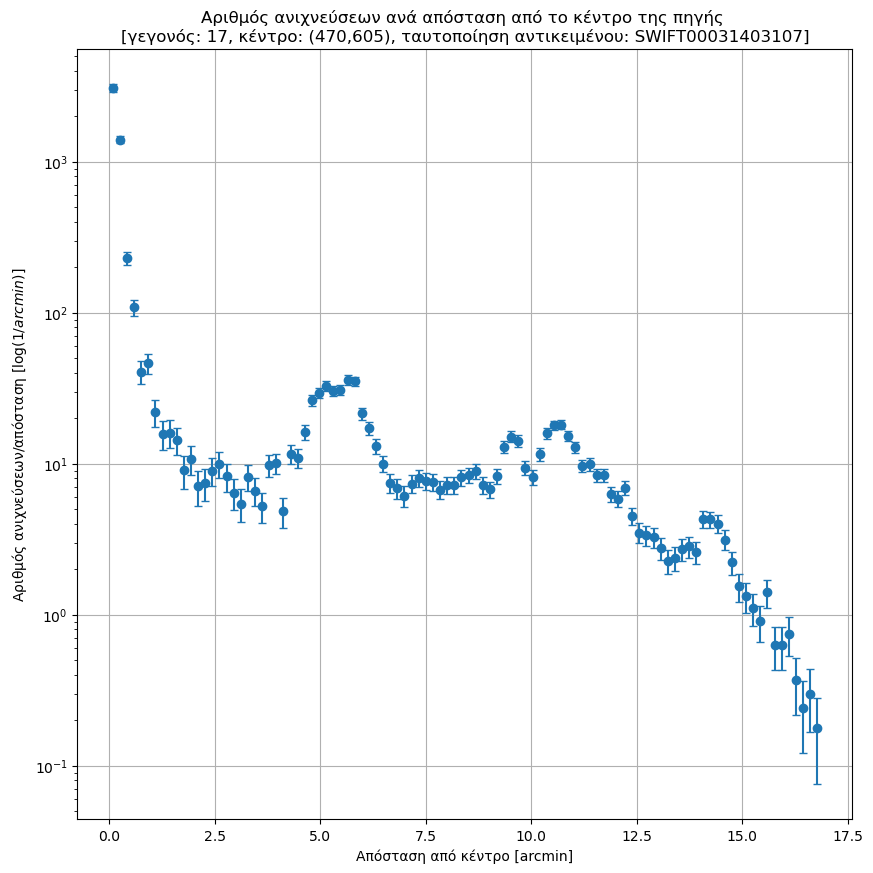

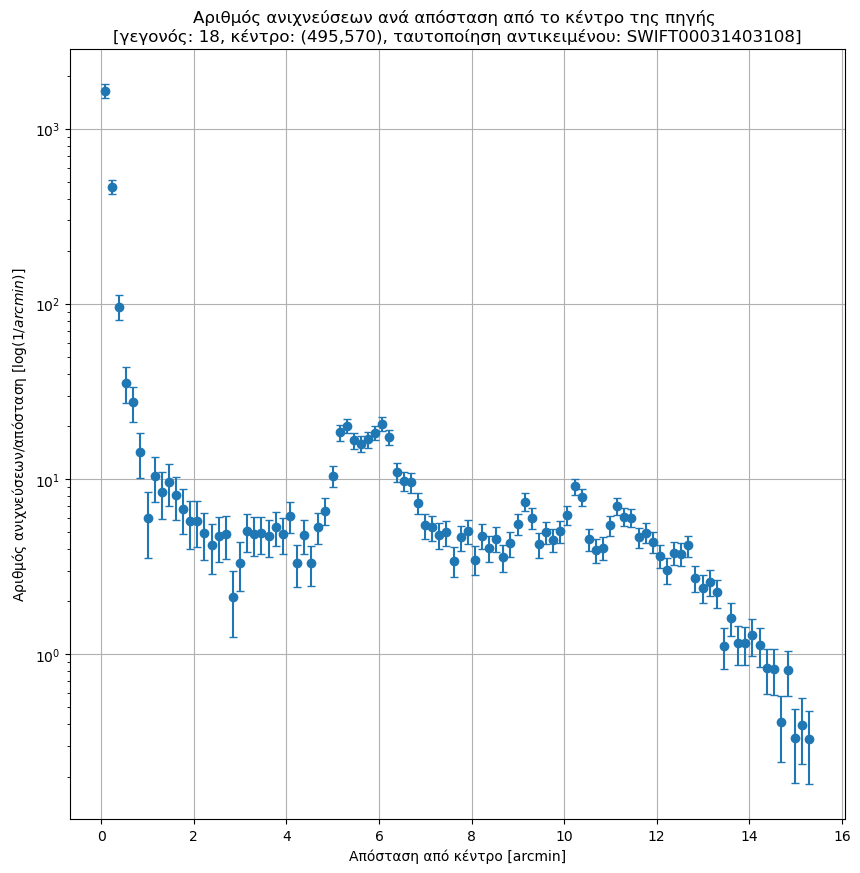

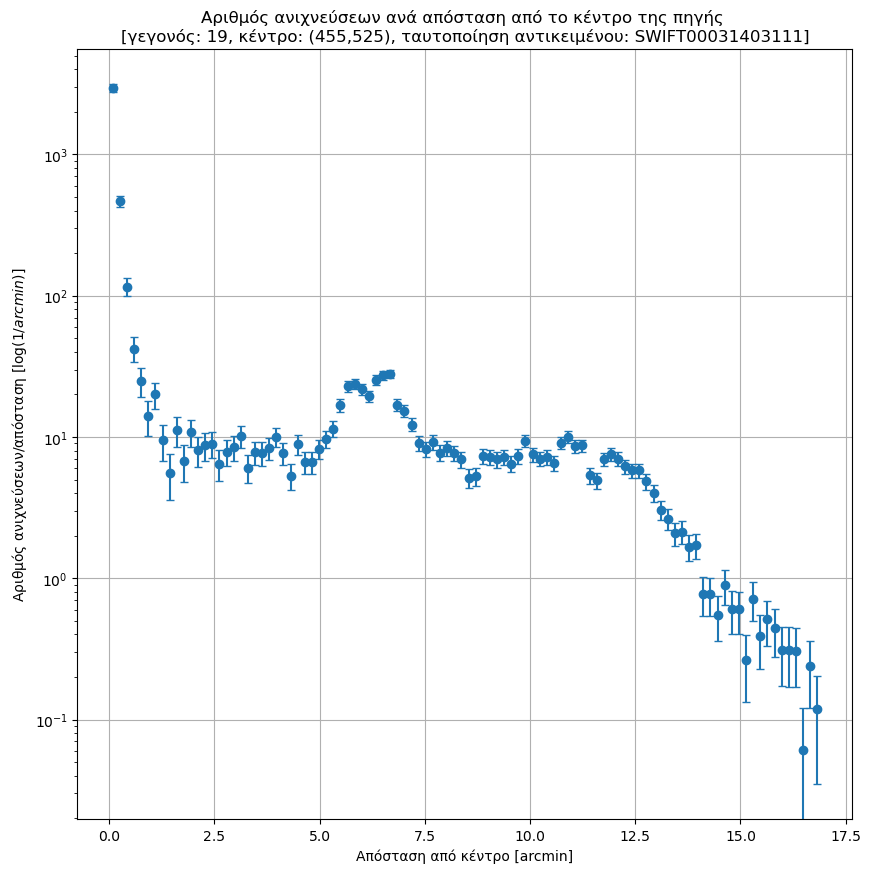

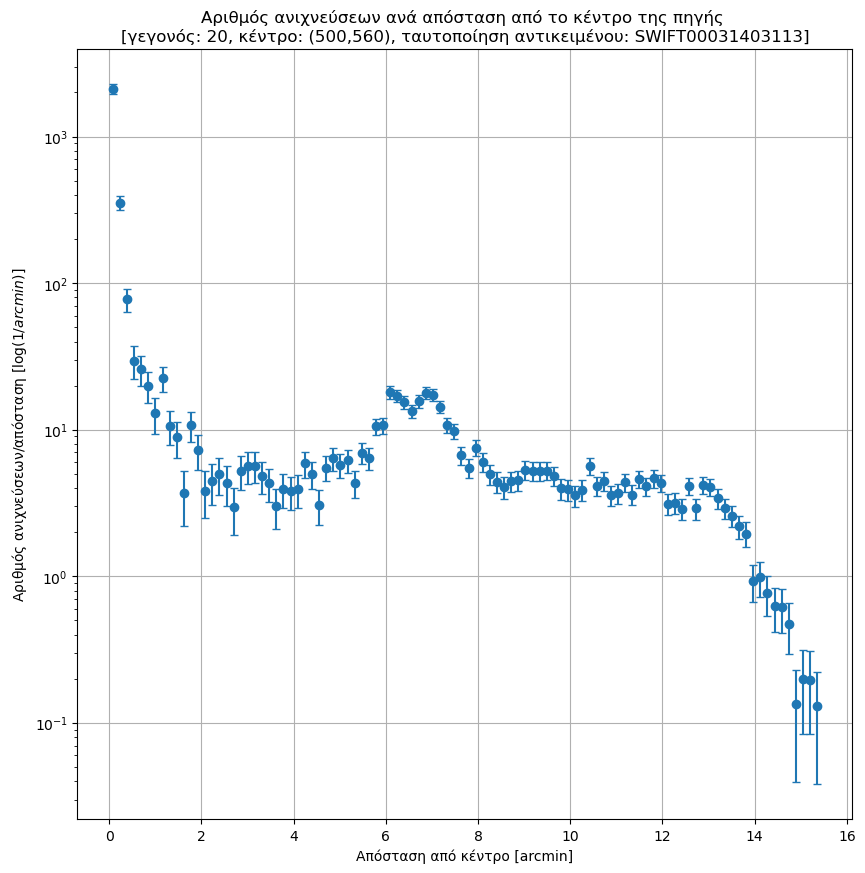

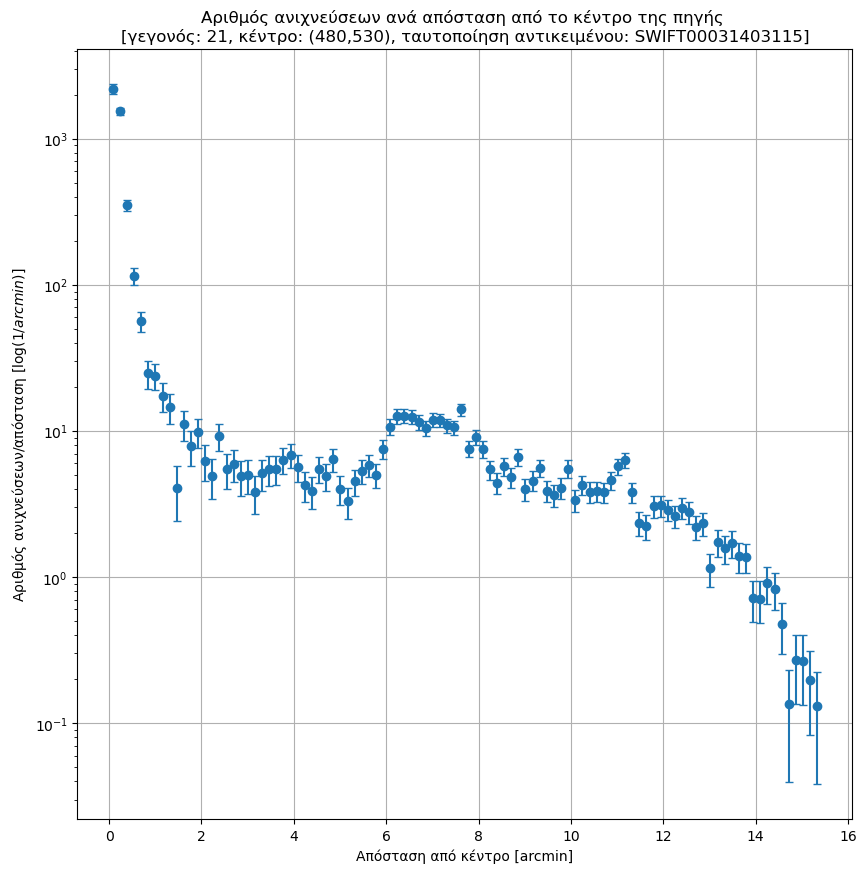

In [171]:
source_origins = [Point(565,585), Point(515,545), Point(495,555), Point(470, 590), Point(475,520), Point(490,550), Point(480,510), Point(475,580), Point(510,500), Point(525,590), Point(540,610), Point(545,585), Point(510,590), Point(485,555), Point(490,555), Point(500,520), Point(440,605), Point(470,605), Point(495,570), Point(455,525), Point(500,560), Point(480,530)]
bin_count = 100

plt.close('all')
get_all_distributions(events, source_origins, bin_count)

#### Χρονοσειρά

In [172]:
local_maxima_file = open("local_maxima.txt", "r")
local_maxima_lines = local_maxima_file.readlines()

local_maxima = np.array([]) # τα τοπικά μέγιστα για κάθε γεγονός
for line in local_maxima_lines:
    local_maxima = np.append(local_maxima, np.array([float(number) for number in line.split()]))

In [173]:
# Τα τοπικά μέγιστα στο local_maxima αφορούν 5 τοπικά μέγιστα που βρέθηκαν
# στα διαγράμματα, με τιμές τους ανά γεγονός, ήτοι ανά τον χρόνο. Τα πρώτα
# δύο μέγιστα έχουν 22 τιμές στον χρόνο, ενώ τα τρία τελευταία μόνο 20. 
# 
# Οι τιμές κάθε μεγίστου ανά τον χρόνο δεν βρίσκονται δίπλα η μία στην άλλη. Με
# άλλα λόγια, οι τιμές που αφορούν ένα τοπικό μέγιστο δεν βρίσκονται σε θέσεις 
# i, i+1 κτλ όπου i κάποιος φυσικός αριθμός.
# Αντ'αυτού, οι τιμές του κάθε τοπικού μεγίστου βρίσκονται στις θέσεις που ανήκουν
# στην ίδια κλάση ισοδυναμίας modulo 5 με τον αριθμό του μεγίστου. Άρα, οι τιμές, π.χ.
# του πρώτου (0) τοπικού μέγιστου βρίσκονται στις θέσεις 0, 5, 10, 15 και 20 του local_maxima.
# Οι τιμές του δεύτερου (1) τοπικού μέγιστου βρίσκονται στις θέσεις 1, 6, 11, 16 και 21 του local_maxima.
# κτλ.

local_maxima_per_time = [np.array([]), np.array([]), np.array([]), np.array([]), np.array([])]

for i in range(len(local_maxima)):
    if not local_maxima[i] == 0:
        local_maxima_per_time[i % 5] =np.append(local_maxima_per_time[i % 5], local_maxima[i])


snipped


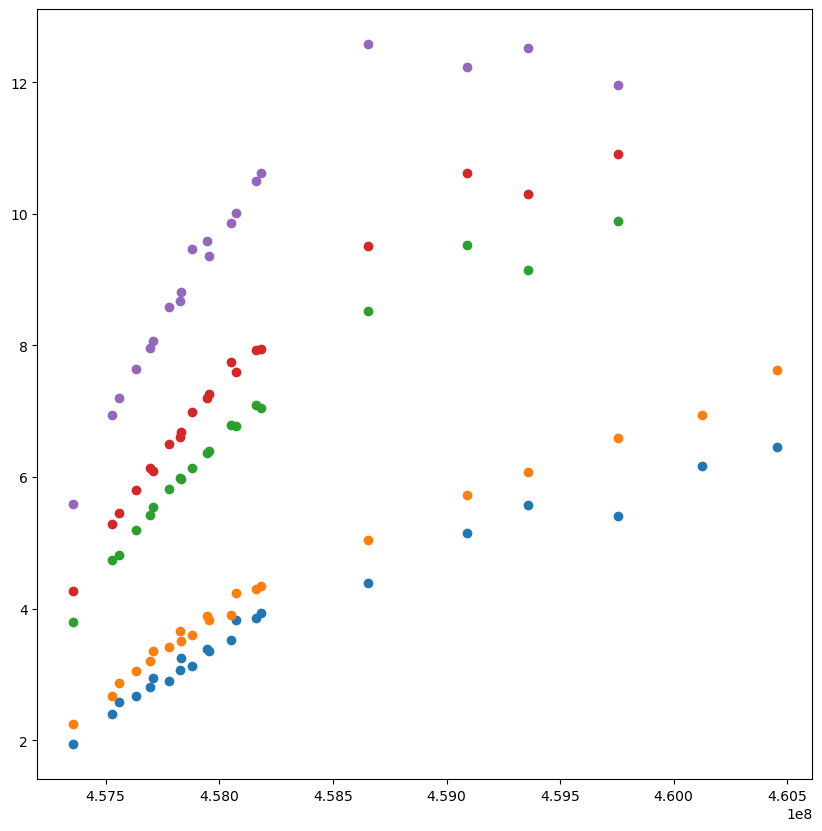

In [174]:
plt.close('all')
figure = plt.figure(1,figsize=(10,10))
snipped = False
event_times_sorted = event_times_sorted_immutable.copy() # να πού χρειάστηκε η προχειροδουλειά
for i in range(len(local_maxima_per_time)):
    if not snipped and i >= 2:
        event_times_sorted.pop()
        event_times_sorted.pop()
        snipped = True
        print("snipped")
    plt.scatter(event_times_sorted, local_maxima_per_time[i])
plt.show()
snipped = False
event_times_sorted = event_times_sorted_immutable.copy() # να πού χρειάστηκε η προχειροδουλειά 


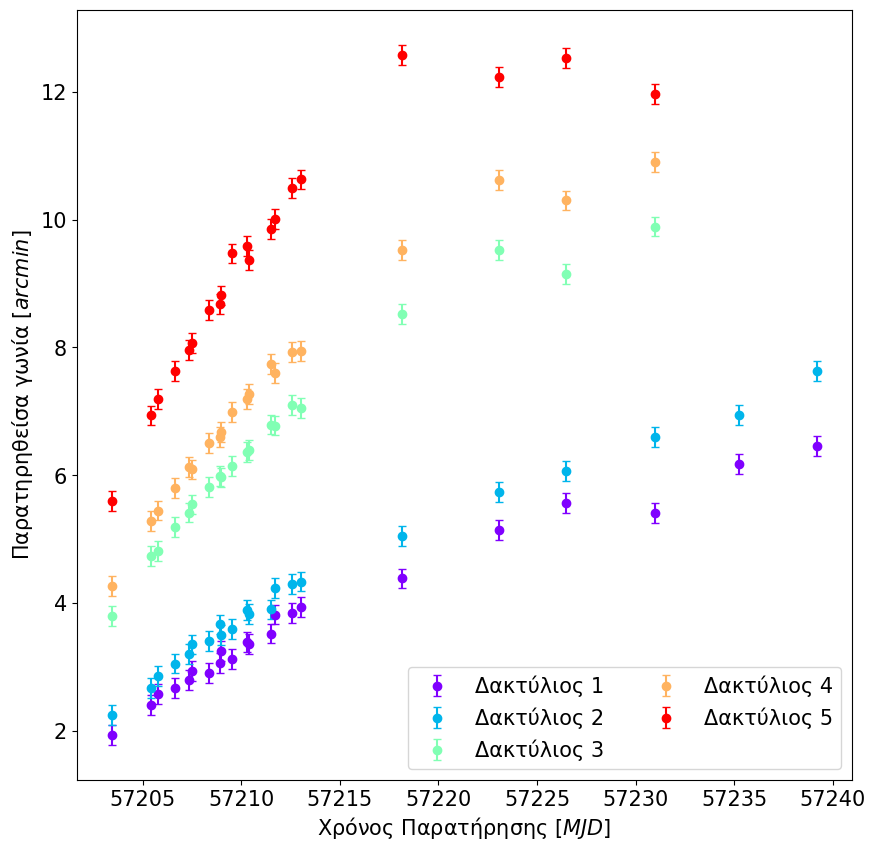

In [175]:
plt.close('all')
figure = plt.figure(1, figsize = (10,10))
rainbow = iter(plt.cm.rainbow(np.linspace(0, 1, len(local_maxima_per_time))))
event_times_MJD = [event_header["MJD-OBS"] for event_header in event_headers] 
event_times_MJD_sliced = event_times_MJD[:len(event_times_MJD)-2]
for i in range(len(local_maxima_per_time)):
    colour = next(rainbow)
    if i<=1:
        plt.errorbar(event_times_MJD, local_maxima_per_time[i], yerr=0.155, fmt='o', capsize=3, label=f"Δακτύλιος {i+1}", color = colour) #Θεωρήσαμε για ευκολία σφάλμα ίσο με την οριζόντια απόσταση μεταξύ δύο γειτονικών σημείων στα ιστογράμματα (0.155 arcmin). 
    else:
        plt.errorbar(event_times_MJD_sliced, local_maxima_per_time[i], yerr=0.155 , fmt='o', capsize=3, label=f"Δακτύλιος {i+1}", color = colour)
plt.xlabel('Χρόνος Παρατήρησης [$MJD$]', fontsize=15)
plt.ylabel('Παρατηρηθείσα γωνία [$arcmin$]', fontsize=15)
plt.legend(loc="lower right", fontsize=15,ncol=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
figure.savefig("maxima_scatter.png")

#### Προσαρμογή καμπύλης
Πρώτη Προσαρμογή: Άγνωστος Χρόνος Έκρηξης

In [176]:
def angle_per_time(time, A, outburst_time):
    return A*np.sqrt(time-outburst_time)

In [177]:
angle_fits_per_time = []

print("\t  A\t\t   Χρόνος Έκρηξης\n----------------------------------------")
for i in range(len(local_maxima_per_time)):
    if i<=1:
         time=event_times_MJD
    else:
         time=event_times_MJD_sliced
    parameters, _ = scipy.optimize.curve_fit(angle_per_time, time, local_maxima_per_time[i], sigma=[0.155]*len(time), p0=[100,57150])
    errors = np.sqrt(np.diag(_))
    angle_fits_per_time += [angle_per_time(time, *parameters)]
    print(i, ": ", ufloat(parameters[0], errors[0]), "\t", ufloat(parameters[1], errors[1]))

	  A		   Χρόνος Έκρηξης
----------------------------------------
0 :  1.036+/-0.014 	 57199.76+/-0.33
1 :  1.192+/-0.009 	 57200.02+/-0.17
2 :  1.83+/-0.04 	 57198.4+/-0.5
3 :  2.03+/-0.04 	 57198.3+/-0.5
4 :  2.31+/-0.12 	 57194.9+/-1.6


C:\Users\toads\AppData\Local\Temp\ipykernel_19876\2790673973.py:2: RuntimeWarning: invalid value encountered in sqrt
  return A*np.sqrt(time-outburst_time)


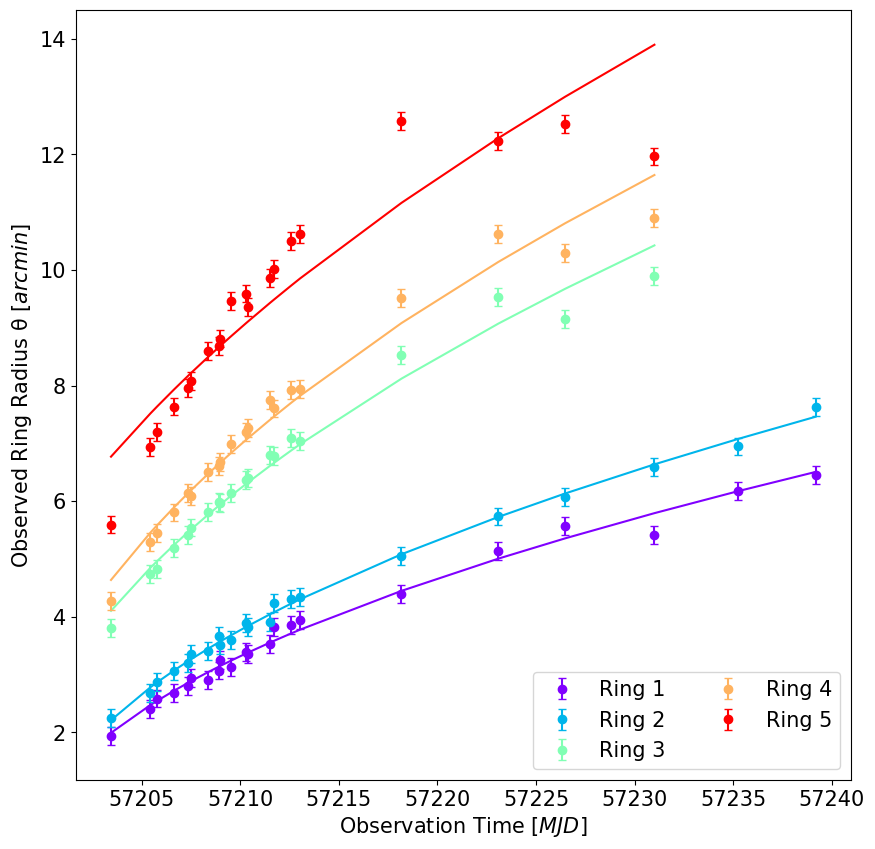

In [178]:
plt.close('all')
figure = plt.figure(1,figsize=(10,10))
rainbow = iter(plt.cm.rainbow(np.linspace(0, 1, len(local_maxima_per_time))))
for i in range(len(local_maxima_per_time)):
    colour = next(rainbow)
    if i<=1:
        time=event_times_MJD
    else:
        time=event_times_MJD_sliced
    plt.errorbar(time, local_maxima_per_time[i], yerr=0.155 , fmt='o', capsize=3, label=f"Ring {i+1}", color = colour)
    plt.plot(time, angle_fits_per_time[i], color = colour)
plt.xlabel('Observation Time [$MJD$]', fontsize=15)
plt.ylabel('Observed Ring Radius θ [$arcmin$]', fontsize=15)
_ = plt.legend(loc="lower right", fontsize=15,ncol=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xlim(57202,57215)
#plt.ylim(0,11.5)
#plt.grid("both")
plt.show()

Βελτίωση προσαρμογής

In [179]:
# Απόρριψη σημείων γεγονότων >= 17, λόγω μεγάλης απόκλισης

event_times_MJD_sliced = event_times_MJD[:16]
local_maxima_per_time_sliced = []
for i in range(len(local_maxima_per_time)):
    local_maxima_per_time_sliced += [local_maxima_per_time[i][:16]]

angle_fits_per_time = []
outburst_times = []
outburst_times_errors = []

print("\t  A\t\t   Χρόνος Έκρηξης\n----------------------------------------")
for i in range(len(local_maxima_per_time)):
    parameters, _ = scipy.optimize.curve_fit(angle_per_time, event_times_MJD_sliced, local_maxima_per_time_sliced[i], sigma=[0.155]*len(event_times_MJD_sliced), p0=[100,57150])
    errors = np.sqrt(np.diag(_))
    angle_fits_per_time += [angle_per_time(event_times_MJD_sliced, parameters[0],parameters[1])]  #Καλύτερα να φιτάρω καποιο Linear σπαψε για να δω που θα πάει η άκρη 
    outburst_times += [parameters[1]]
    outburst_times_errors += [errors[1]]
    print(i, ": ", ufloat(parameters[0], errors[0]), "\t", ufloat(parameters[1], errors[1]))

	  A		   Χρόνος Έκρηξης
----------------------------------------
0 :  1.085+/-0.023 	 57200.45+/-0.33
1 :  1.204+/-0.021 	 57200.16+/-0.28
2 :  1.954+/-0.012 	 57199.62+/-0.10
3 :  2.209+/-0.018 	 57199.73+/-0.14
4 :  2.916+/-0.033 	 57199.78+/-0.19


C:\Users\toads\AppData\Local\Temp\ipykernel_19876\2790673973.py:2: RuntimeWarning: invalid value encountered in sqrt
  return A*np.sqrt(time-outburst_time)


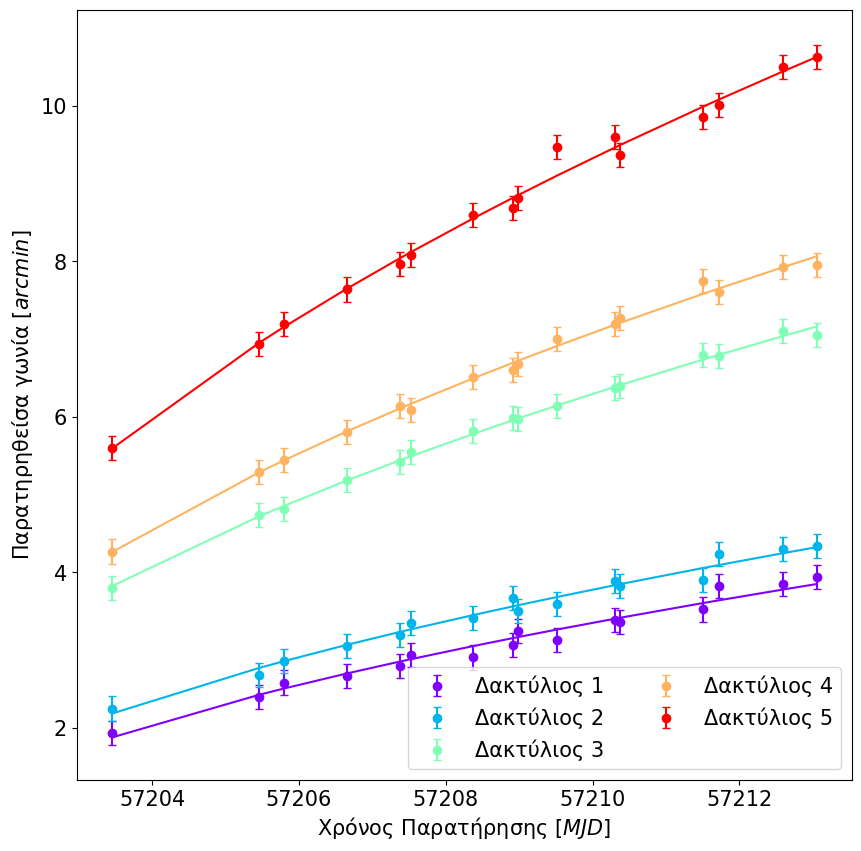

In [180]:

plt.close('all')
figure = plt.figure(1,figsize=(10,10))
rainbow = iter(plt.cm.rainbow(np.linspace(0, 1, len(local_maxima_per_time_sliced))))
for i in range(len(local_maxima_per_time_sliced)):
    colour = next(rainbow)
    plt.errorbar(event_times_MJD_sliced, local_maxima_per_time_sliced[i], yerr=0.155 , fmt='o', capsize=3, label=f"Δακτύλιος {i+1}", color = colour)
    plt.plot(event_times_MJD_sliced, angle_fits_per_time[i], color = colour)
plt.xlabel('Χρόνος Παρατήρησης [$MJD$]', fontsize=15)
plt.ylabel('Παρατηρηθείσα γωνία [$arcmin$]', fontsize=15)
plt.legend(loc="lower right", fontsize=15,ncol=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### Υπολογισμός σταθμισμένου μέσου όρου για τον χρόνο έκρηξης

In [181]:
weight = [(1/(error)**2) for error in outburst_times_errors]
weighted_times = [weight*time for time, weight in zip(outburst_times, weight)]

mean_outburst_time = sum(weighted_times)/sum(weight)
outburst_time_error = math.sqrt(1/sum(weight))
time_table = pd.DataFrame({'wi [1/MJD]':weight, 'wi*t_i':weighted_times})
time_table.style 

print("Σταθμισμένος μέσος χρόνου έκρηξης:")
print(ufloat(mean_outburst_time, outburst_time_error))

Σταθμισμένος μέσος χρόνου έκρηξης:
57199.75+/-0.07


#### Προσαρμογή για δεδομένη απόσταση κ' χρόνο έκρηξης

In [182]:
a_params = []
angle_fits_per_time = []
print("\t  A\n-------------------")
for i in range(len(local_maxima_per_time)):
    parameters, _ = scipy.optimize.curve_fit(lambda t, A: angle_per_time(t, A, mean_outburst_time), event_times_MJD_sliced, local_maxima_per_time_sliced[i], sigma=[0.155]*len(event_times_MJD_sliced))
    error = np.sqrt(np.diag(_))
    angle_fits_per_time += [angle_per_time(event_times_MJD_sliced, parameters[0], mean_outburst_time)]
    a_params += [parameters[0]]
    print(i, ": ", ufloat(parameters[0], error[0]))


	  A
-------------------
0 :  1.042+/-0.009
1 :  1.177+/-0.007
2 :  1.968+/-0.004
3 :  2.211+/-0.006
4 :  2.912+/-0.010


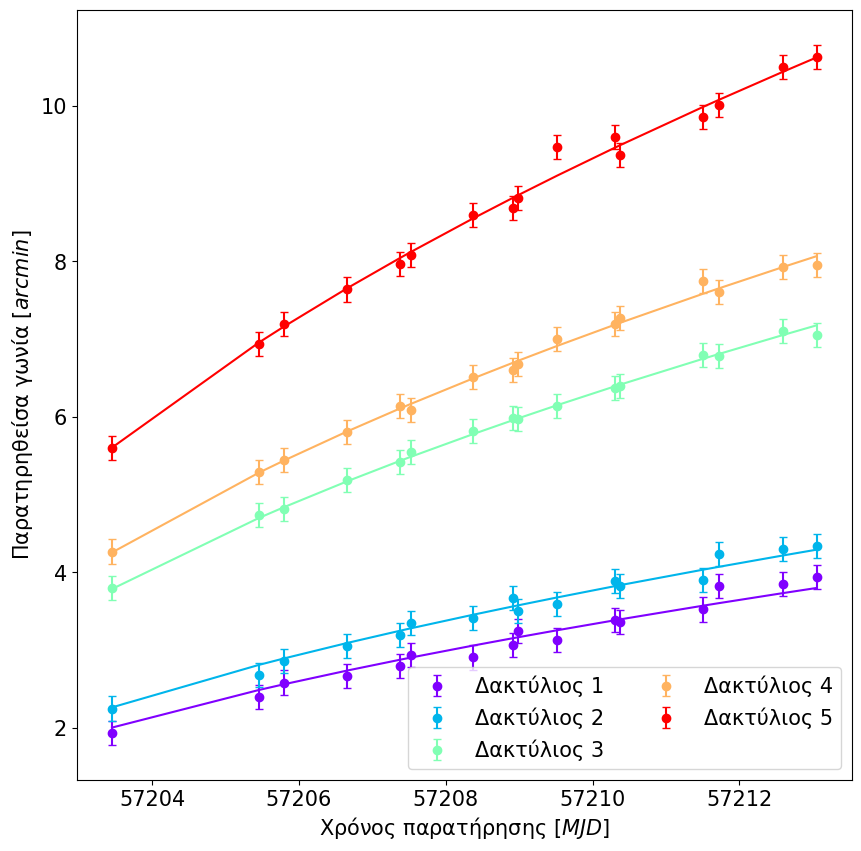

In [183]:
plt.close('all')
figure = plt.figure(1,figsize=(10,10))
rainbow = iter(plt.cm.rainbow(np.linspace(0, 1, len(local_maxima_per_time_sliced))))
for i in range(len(local_maxima_per_time_sliced)):
    colour = next(rainbow)
    plt.errorbar(event_times_MJD_sliced, local_maxima_per_time_sliced[i], yerr=0.155 , fmt='o', capsize=3, label=f"Δακτύλιος {i+1}", color = colour)
    plt.plot(event_times_MJD_sliced, angle_fits_per_time[i], color = colour)
plt.xlabel('Χρόνος παρατήρησης [$MJD$]', fontsize=15)
plt.ylabel('Παρατηρηθείσα γωνία [$arcmin$]', fontsize = 15)
_ = plt.legend(loc="lower right", fontsize=15,ncol=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### Εύρεση σταθεράς x
$$ A^2 = \frac{19.84(1-x)}{x}\frac{1\;\text{kpc}}{d} \Rightarrow$$
$$ x = \frac{19.84}{d(A^2 + 19.84)}\text{kpc}$$

In [184]:
def x_constant(A, distance): # σε arcmin
    return 19.84/(distance*(A**2 + 19.84))

In [185]:
distance = ufloat(2.39,0.14)

for param in a_params:
    print(x_constant(param, distance))

0.397+/-0.023
0.391+/-0.023
0.350+/-0.021
0.336+/-0.020
0.293+/-0.017


#### Προσαρμογή Ακτινών Δακτυλίων
Για το πρώτο γεγονός μόνον

In [186]:
def normal_dist(x, x0, width, deviation): 
    return width*(np.exp(-(x-x0)**2)/(2*deviation**2))

def ring_histogram(x, a, b, x01, x02, x03, x04, width1, width2, width3, width4, dev1, dev2, dev3, dev4):
    return a*np.exp(-b*x) + normal_dist(x, x01, width1, dev1) + normal_dist(x, x02, width2, dev2) + normal_dist(x, x03, width3, dev3) + normal_dist(x, x04, width4, dev4)

In [187]:
unit_bin_middles, counts = get_distribution_of_first_event(events, source_origin, bin_count)

parameters, _ = scipy.optimize.curve_fit(ring_histogram, unit_bin_middles, counts)
fitted_local_maxima_per_time = [ring_histogram(bin_middle, parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5],parameters[6],parameters[7],
                                              parameters[8],parameters[9],parameters[10],parameters[11],parameters[12],parameters[13]) for bin_middle in unit_bin_middles]


C:\Users\toads\AppData\Local\Temp\ipykernel_19876\1572518170.py:5: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x) + normal_dist(x, x01, width1, dev1) + normal_dist(x, x02, width2, dev2) + normal_dist(x, x03, width3, dev3) + normal_dist(x, x04, width4, dev4)
C:\Users\toads\AppData\Local\Temp\ipykernel_19876\1572518170.py:5: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(-b*x) + normal_dist(x, x01, width1, dev1) + normal_dist(x, x02, width2, dev2) + normal_dist(x, x03, width3, dev3) + normal_dist(x, x04, width4, dev4)
d:\toads\Apps\miniconda\envs\astrolab\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


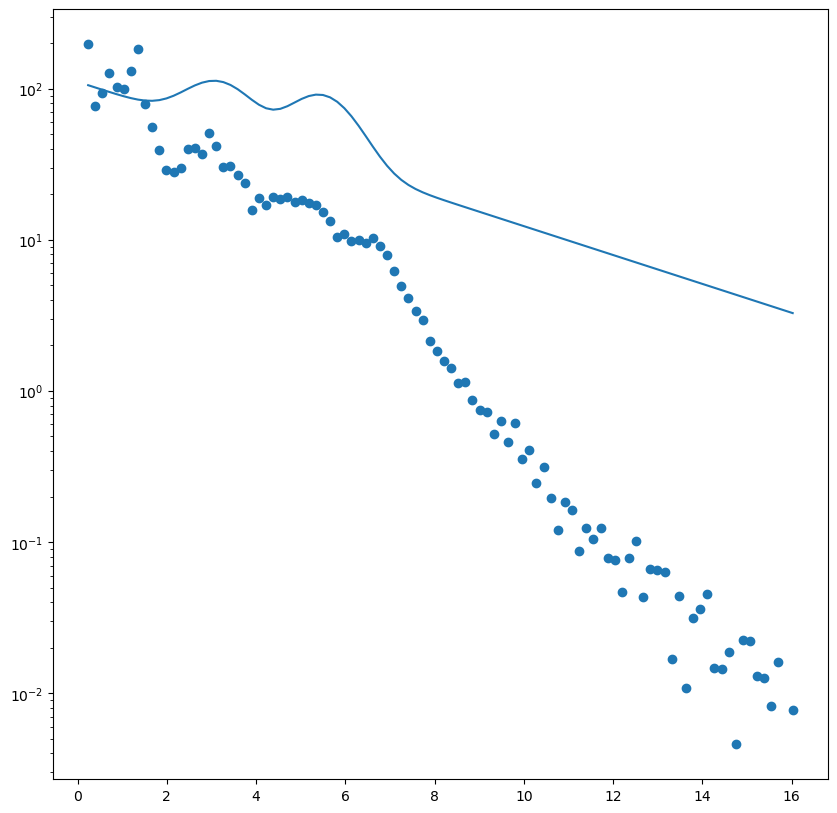

In [188]:
plt.close('all')
figure = plt.figure(1,figsize=(10,10))
plt.scatter(unit_bin_middles, counts/unit_bin_middles)
plt.plot(unit_bin_middles, fitted_local_maxima_per_time)
plt.yscale("log")
plt.show()